In [2]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph
from utils.graph_builder import draw_dot

## Building the Value Object: Gradients and Backpropagation

Now that we're familiar with derivatives and have applied the chain rule throughout our computational graph, we need to incorporate this into our `Value` object. This will allow us to systematically apply backpropagation whenever needed. Essentially, we want to be able to "push a button" and propagate gradients through our entire computational graph, regardless of its complexity.

To calculate gradients across the entire Directed Acyclic Graph (DAG) of operations, we need to compute the derivative of the final expression with respect to each specific node.

First, we need to create a `grad` variable inside the Value class and initialize it to `0.0`. This allows each `Value` node to store its gradient, which is the derivative of the final `Value` node \( L \) with respect to the node of interest itself.

Next, we need to define the appropriate backward function for each operation in the Value object. By examining a node in a general way, we can derive a universal expression to easily swap in the correct derivative expression. Every time we perform an operation on a Value object, we pass in `self`, `other`, or just `self`. We aim to design a method to calculate the gradients of the `self` and `other` objects, allowing the gradient to flow through the resulting Value object from the operation on the child nodes.

In [4]:
# Defining the value Class up to this point
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = 0.0
        self._backward = lambda:None 
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

In [5]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

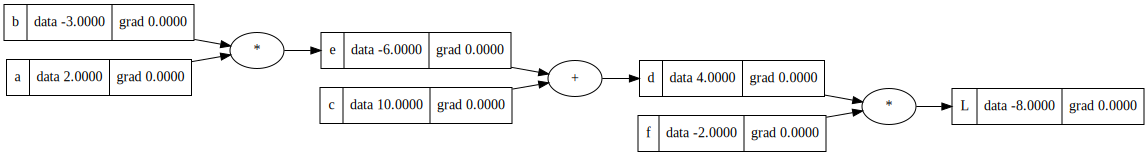

In [6]:
draw_dot(L)

## Define the Backward Functions

Now we want to define the right backward function for each operation in the value object.  We can look at a node in a general way and derive a general expression so we can easily swap in the right derivative expression. Every time we call an operation on a Value object, we pass in self, other, or just self. We want to engineer a way to calculate the gradients of the self and other objects, by letting it flow through the out value object that results from the operation on the children nodes.

<table style="width:100%">
  <tr>
    <td style="width:50%; vertical-align:top;">
      <img src="Assets/op_backward.png" alt="Diagram" style="width:100%;"/>
    </td>
    <td style="width:50%; vertical-align:top;">
      $$
      \begin{aligned}
      \frac{\partial L}{\partial \text{self}} &= \frac{\partial L}{\partial \text{out}} \cdot \frac{\partial \text{out}}{\partial \text{self}} \\
      \frac{\partial L}{\partial \text{other}} &= \frac{\partial L}{\partial \text{out}} \cdot \frac{\partial \text{out}}{\partial \text{other}} \\
      \frac{\partial L}{\partial \text{out}} &= \text{expression for } \frac{\partial L}{\partial \text{out}}
      \end{aligned}
      $$
    </td>
  </tr>
</table>

This translates into a closure we can define for each operation, and we simply need to apply the right derivative rule for each operation (derivatives cheatsheet) and plug that into the formulas we derived above. The Value object, with all the _backward() functions implemented, looks like this:

In [7]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward 

        return out 
    
    def __radd__(self, other):  # For handling float + Value
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out    
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self): # - self
        return self * -1 

    def __sub__(self, other): # self - other
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward 
        
        return out
    
    def exp(self):
        x = self.data 
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out 

Why the +=? we need to make sure we accumulate the gradients. in the example we used so far this was not necessary as it was a very simple example. However, we need to realise that a single node can be involved in multiple operations (this will become apparent in a Neural Network example). As we traverse the DAG we want therefore to accumulate the gradients from all paths that affect a given parameter. 

# DAG Traversal

Now that we have the individual building blocks of gradients expression, we want to backpropagate through the entire DAG, starting from the root node (which is the last one) and call the _backward() function in the topological order. We use a Depth-First Search (DFS)-based topological sort algorithm to achieve that. Topological sorting is crucial to ensure all gradients are computed in the right order, respecting the dependencies between operations in our case.

## DFS Topological Sort

Example to illustrate the algorithm 

<table style="width:100%">
  <tr>
    <td style="width:50%; vertical-align:top;">
      $$
      \begin{aligned}
      z &= x + y \\
      w &= z \cdot u \\
      L &= \tanh(w)
      \end{aligned}
      $$
    </td>
    <td style="width:50%; vertical-align:top;">
      <pre>
 x   y   u
  \ /    |
   z     |
    \   /
     w
     |
     L
      </pre>
    </td>
  </tr>
</table>

In [12]:
# Create the values
x = Value(2.0, label='x')
y = Value(3.0, label='y')
u = Value(1.0, label='u')

# Define the expressions
z = x + y; z.label = 'z'
w = z * u; w.label = 'w'
L = w.tanh(); L.label = 'L'

# Topological sorting algorithm
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

# Build the topological order
build_topo(L)

# Print the topological order
for node in topo:
    print(node.label)

u
x
y
z
w
L


1. **Visit L**:
   - L is not visited, so mark it as visited.
   - Recursively visit its dependency (child: w).

2. **Visit w**:
   - w is not visited, so mark it as visited.
   - Recursively visit its dependencies (children: z and u).

3. **Visit u**:
   - u is not visited, so mark it as visited.
   - u has no dependencies (children), so add u to topo: `topo = [u]`.
   - Return from `build_topo(u)` to continue with the next child of w.

4. **Visit z**:
   - z is not visited, so mark it as visited.
   - Recursively visit its dependencies (children: x and y).

5. **Visit x**:
   - x is not visited, so mark it as visited.
   - x has no dependencies (children), so add x to topo: `topo = [u, x]`.
   - Return from `build_topo(x)` to continue with the next child of z.

6. **Visit y**:
   - y is not visited, so mark it as visited.
   - y has no dependencies (children), so add y to topo: `topo = [u, x, y]`.
   - Return from `build_topo(y)` to complete visiting all children of z.

7. **Add z**:
   - All dependencies (children) of z are visited (x and y).
   - Add z to topo: `topo = [u, x, y, z]`.
   - Return from `build_topo(z)` to complete visiting all children of w.

8. **Add w**:
   - All dependencies (children) of w are visited (z and u).
   - Add w to topo: `topo = [u, x, y, z, w]`.
   - Return from `build_topo(w)` to complete visiting all children of L.

9. **Add L**:
   - All dependencies (children) of L are visited (w).
   - Add L to topo: `topo = [u, x, y, z, w, L]`.

The final topological order will be `topo = [u, x, y, z, w, L]`.

## Adding DFS to the Value class

We now want to hide this functionality inside the Value class. Let’s add this to our value class

In [13]:
# defining the final Value class
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward 

        return out 
    
    def __radd__(self, other):  # For handling float + Value
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out    
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self): # - self
        return self * -1 

    def __sub__(self, other): # self - other
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward 
        
        return out
    
    def exp(self):
        x = self.data 
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out 

    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited: 
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

## Neuron Example

Example of backpropagation calculated automatically on the same neuron we used to calculate the gradients manually before

In [14]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron (it is a weird number to make other numbers look better)
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

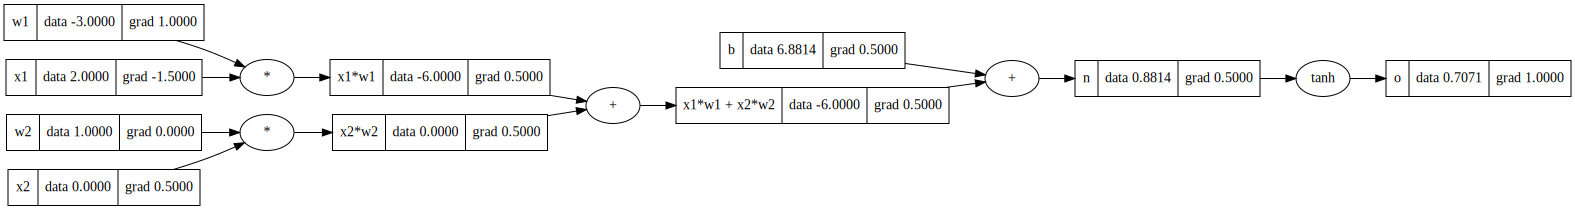

In [15]:
draw_dot(o)